In [1]:
import json
import re
import os
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

from calcimetry.mongo_api import MongoInfo, MongoAPI

In [2]:
mongo_info = MongoInfo()

dirhead = '/work/armitagj/data/csvs/REP4/'
drillfiles = [ f.path for f in os.scandir(dirhead) if f.is_dir() ]
filename = 'imgs2.csv'
mesuname = 'mesu.csv'

# location of calcimetry files fo case where mesu.csv does not exist
calcihead = '/work/armitagj/data/Excell_and_Photos/'

checkfile = []
checkexcel = []

# loop through all directories on the local system
for drill in drillfiles:

    # grab the only diretory (not always called "Photos")
    images = [ f.path for f in os.scandir(drill) if f.is_dir() ]
    csvfile = images[0] + '/' + filename
    calcifile = images[0] + '/' + mesuname

    try:
        # If the images have been processed
        if os.path.isfile(csvfile):

            # get the database DrillName from the directory name (some
            # DrillName entries have extra numbers)
            with MongoAPI(mongo_info=mongo_info) as mongo_api:
                drillname = drill.split('/')[-1]
                partialdrillname = f'.*{drillname}.*'
                doc = mongo_api.db['images'].find_one({'DrillName': {'$regex' : partialdrillname}})
                realdrillname = doc['DrillName']

                if mongo_api.db['measurements'].find_one({'DrillName': realdrillname}) is None:
                    # If Renaud has already created a mesu.csv file
                    if os.path.isfile(calcifile):

                        # read file
                        df = pd.read_csv(calcifile, delimiter=';')
                        
                        if len(df) < 1:
                            checkfile.append(drillname)
                            print(f'{drillname} : mesu.csv has {len(df)} rows')

                        del df

                    # Otherwise let's create the mesu.csv file from the Excel one
                    # NOTE: I don't have the mesurement ID for now, fix this
                    # once all the data is in the database
                    
                    elif drillname == 'SUG1201' or drillname == 'SUG1202':
                        df1 = pd.read_csv(excell2csved[0], sep=',')
                        df2 = pd.read_csv(csvfile, sep=';', encoding='cp1252')
                    
                    
                    else:
                        print('creating')

                        # grab the csv file I create with exell2csv.py
                        excell2csved = glob.glob(calcihead +
                                                 drill.split('/')[-1] +
                                                 '/*.csv')

                        print(excell2csved)
                        df1 = pd.read_csv(excell2csved[0], sep=',')
                        df2 = pd.read_csv(csvfile, sep=',')

                        # Modify Renaud's code to create a local mesu.csv
                        # file, so that it is identical to those already
                        # created

                        # I don't have a unique ID for the measurement,
                        # fix this once the database is complete
                        id = np.nan

                        with open(calcifile, 'w') as g:
                            g.write("MeasureId;ImageId;CalciCote;CalciVals1m;CalciVals15m\n")
                            for i, row2 in df2.iterrows():
                                imgId = row2["ImageId"]
                                cote0 = row2["Cote0"]
                                cote1 = row2["Cote1"]
                                for j, row1 in df1.iterrows():
                                    c = np.rint(row1["Cote"] * 100)
                                    if cote0 <= c and c <= cote1:
                                        g.write(f'{id};{imgId};{c};'
                                                f'{df1.iloc[j, 2]};'
                                                f'{df1.iloc[j, 4]}\n')
                            g.close()

                        # read file back in (I know...)
                        df = pd.read_csv(calcifile, delimiter=';')

                        print(f'{drillname} : new mesu.csv has {len(df)} rows')
                        
                        if len(df) < 1:
                            checkexcel.append(drillname)

                        del df1, df2, df
                else:
                    # If Renaud has already created a mesu.csv file
                    if os.path.isfile(calcifile):

                        # read file
                        df = pd.read_csv(calcifile, delimiter=';')
                        
                        
                        if len(df) < 1:
                            checkfile.append(drillname)
                            print(f'{drillname} : mesu.csv has {len(df)} rows')

                        del df
        else:
            print(f'No imgs2.csv file for drill {drill}')

    # print error messages so I can try and fix them and import them
    # idividually
    except Exception as e:
        print(drill)
        print(e)


No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR1001
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR1002
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR1003
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR2001
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR2002
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/DIR2003
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/IBE2003
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ6562
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ6563
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ6564
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ6565
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ7004
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ7006
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ7008
No imgs2.csv file for drill /work/armitagj/data/csvs/REP4/OHZ7101
No imgs2.c

In [3]:
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    drillnames = mongo_api.db['images'].distinct('DrillName')

In [4]:
print(len(drillnames))

134


In [12]:
dirhead = '/work/armitagj/data/csvs/REP4/'
drillfiles = [ f.path for f in os.scandir(dirhead) if f.is_dir() ]
filename = 'imgs2.csv'
mesuname = 'mesu.csv'

data = []

# loop through all directories on the local system
for drill in drillfiles:

    
    # grab the only diretory (not always called "Photos")
    images = [ f.path for f in os.scandir(drill) if f.is_dir() ]
    csvfile = images[0] + '/' + filename
    calcifile = images[0] + '/' + mesuname

    with MongoAPI(mongo_info=mongo_info) as mongo_api:
        drillname = drill.split('/')[-1]
        partialdrillname = f'.*{drillname}.*'
        if mongo_api.db['images'].find_one({'DrillName': {'$regex' : partialdrillname}}) is not None:
            docs = mongo_api.db['images'].find({'DrillName': {'$regex' : partialdrillname}})
            df = pd.DataFrame(list(docs))
        
            data.append([drillname, len(df)])

            local_file = open(csvfile, 'r+', encoding='cp1252')
            reader_file = csv.reader(local_file)
            data.append([drillname, len(list(reader_file)) - 1])
            local_file.close()
            
            del df

In [13]:
df = pd.DataFrame(data, columns=['name', 'number of entries'])
df

,name,number of entries
0,BPE4023,8
1,BPE4023,8
2,BPE4024,8
3,BPE4024,8
4,DCN2001,16
...,...,...
263,TER1302,21
264,TPV1321,65
265,TPV1321,65
266,TPV1322,78


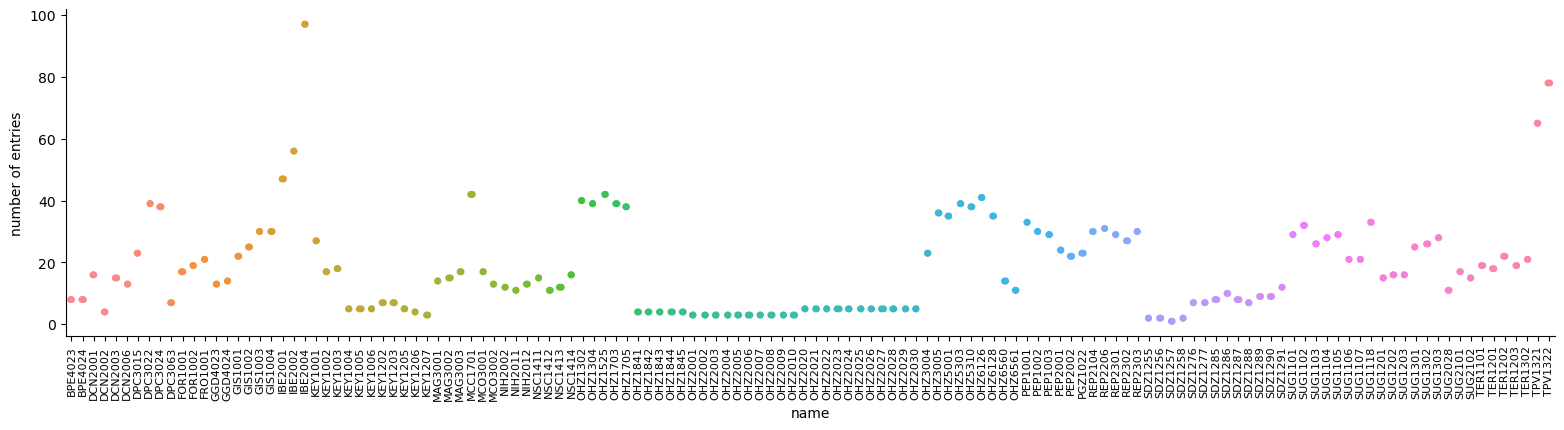

In [14]:
g = sns.catplot(x='name', y='number of entries', data=df, height=4, aspect=4)
g.set_xticklabels(rotation=90, fontsize=8)

In [15]:
data = []

# loop through all directories on the local system
for drill in drillfiles:

    # grab the only diretory (not always called "Photos")
    images = [ f.path for f in os.scandir(drill) if f.is_dir() ]
    csvfile = images[0] + '/' + filename
    calcifile = images[0] + '/' + mesuname

    with MongoAPI(mongo_info=mongo_info) as mongo_api:
        drillname = drill.split('/')[-1]
        partialdrillname = f'.*{drillname}.*'
        if mongo_api.db['measurements'].find_one({'DrillName': {'$regex' : partialdrillname}}) is not None:
            docs = mongo_api.db['measurements'].find({'DrillName': {'$regex' : partialdrillname}})
            df = pd.DataFrame(list(docs))
        
            data.append([drillname, len(df)])

            local_file = open(calcifile, 'r+', encoding='cp1252')
            reader_file = csv.reader(local_file)
            data.append([drillname, len(list(reader_file)) - 1])
            local_file.close()

            del df

In [16]:
df = pd.DataFrame(data, columns=['name', 'number of entries'])
df

,name,number of entries
0,BPE4023,29
1,BPE4023,29
2,BPE4024,31
3,BPE4024,31
4,DCN2001,37
...,...,...
263,TER1302,22
264,TPV1321,31
265,TPV1321,31
266,TPV1322,26


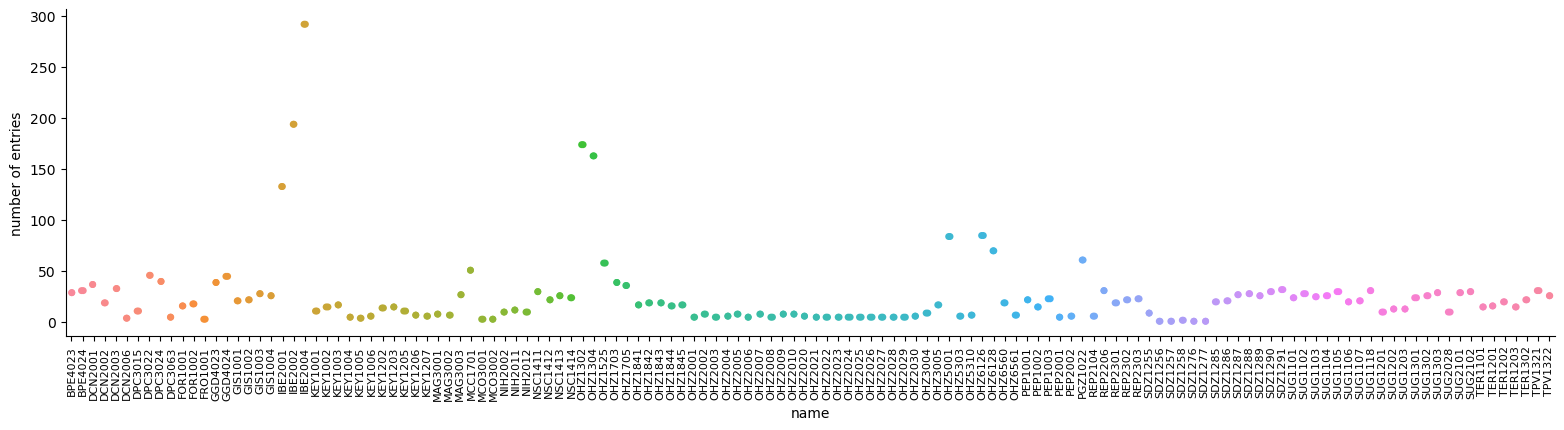

In [17]:
g = sns.catplot(x='name', y='number of entries', data=df, height=4, aspect=4)
g.set_xticklabels(rotation=90, fontsize=8)